# Replication Results - Final Analysis
- 1. Try to randomly pick 100 multi-word phrases whose scores are greater than 0.5. Manually check them and see what's the percentage of high-quality phrases.
- 2. Since these 100 multi-word phrases can be ranked by their scores, please plot a precision-recall curve too.
- 3. Try to run the word2vec code on the phrasal segmentation results to obtain phrase embedding. 
- 4. Pick 3 high-quality phrases from your previous annotations in step 1, run a similarity search among all multi-word phrases whose scores are greater than 0.5, and report the top-5 results. Comment on the results. 



In [34]:
# !pip install gensim

In [5]:
from os import listdir
import pandas as pd
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import re
from gensim.models import Word2Vec
import pickle
import numpy as np

In [2]:
out_file_dir = '../data/out/DBLP/'
data_dir = '../data/'

In [3]:
phrases = []
scores = []
for f in listdir(out_file_dir):
    if 'multi-words' in f:
        multi_words = open(out_file_dir + f, 'r')
        for line in multi_words:
            line_txt = line.split()
            score = line_txt[0]
            scores.append(float(score))
            phrase = ' '.join(line_txt[1:])
            phrases.append(phrase)
        break
all_scores = pd.DataFrame({'phrase': phrases, 'score': scores})

FileNotFoundError: [Errno 2] No such file or directory: '../data/out/DBLP/'

In [ ]:
all_scores.shape

- **1. Randomly draw 100 phrases and check quality**

In [5]:
selected_phrases = all_scores.query('score > 0.5').sample(100, random_state = 42).sort_values(by = 'score', ascending = False)\
    .reset_index(drop = True)
selected_phrases.head()

,phrase,score
0,grocery shopping,0.965547
1,class diagrams,0.943706
2,minwise hashing,0.940578
3,parallel discrete event simulation,0.913498
4,stock exchanges,0.902545


In [6]:
# selected_phrases.to_csv('sample_scores.csv', index = False)

- **2. precision-recall curve**

In [7]:
selected_phrases = pd.read_csv('../references/sample_scores.csv')
selected_phrases.head()

,phrase,score,Label
0,grocery shopping,0.965547,1
1,class diagrams,0.943706,1
2,minwise hashing,0.940578,1
3,parallel discrete event simulation,0.913498,1
4,stock exchanges,0.902545,1


In [8]:
y_true = selected_phrases.Label.values
y_scores = selected_phrases.score.values
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
# precision, recall, thresholds

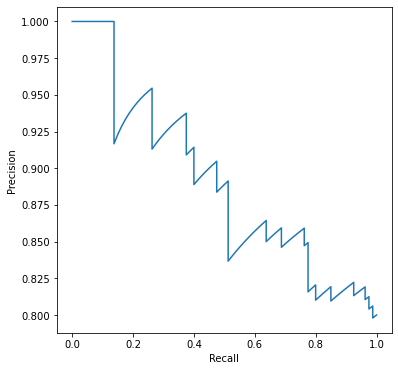

In [9]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(recall, precision, label='Logistic Regression')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision');

- **3. Segmentation result & word2vec**

In [10]:
def search_single_line(line):
    if '<phrase>' in line:
        curr_phrases = []
        for i in line.split('<phrase>'):
            if i.strip() == '':
                continue
            first = True
            for ph in i.split('</phrase>'):
                if first:
                    curr_phrases.append('_'.join(ph.split()))
                    first = False
                else:
                    for w in ph.split():
                        curr_phrases.append(w.strip())
        return curr_phrases
    else:
        return line.split()

In [11]:
# result = open(data_dir + 'models/DBLP/segmentation.txt', 'r')
# counter = 0
# for line in result:
#     if 'eth_zurich' not in line:
#         continue
#     print(line)
#     print(search_single_line(line))
#     print('=========')
#     counter += 1
#     if counter == 30:
#         break

In [12]:
result = open(data_dir + 'models/DBLP/segmentation.txt', 'r')
counter = 0
all_sents = []
for line in result:
    if line.strip() == '' or line.strip() == '.':
        continue
    all_sents.append(search_single_line(line))

In [13]:
# sample_str = '<phrase>Multimedia</phrase> <phrase>Information</phrase> Systems: Issues and Approaches.'
# re.sub('<phrase>[^<]+</phrase>', )

In [14]:
len(all_sents)

2773466

In [15]:
all_sents[:3]

[['OQL',
  '[',
  'C++',
  ']:',
  'Extending',
  'C++',
  'with',
  'an',
  'Object',
  'Query',
  'Capability.'],
 ['Transaction_Management', 'in', 'Multidatabase_Systems', '.'],
 ['Overview', 'of', 'the', 'ADDS', 'System.']]

In [16]:
# pickle.dump(all_sents, open('../data/tmp/all_sents.pickle', 'wb'))

In [ ]:
model = Word2Vec(all_sents, min_count = 5, size = 50, workers = 2, window = 3, sg = 0)

In [ ]:
# model.save("../references/word2vec.model")

- **4. Pick 3 high-quality phrases from your previous annotations in step 1, run a similarity search among all multi-word phrases whose scores are greater than 0.5, and report the top-5 results. Comment on the results.**

In [32]:
selected_high_quality_phrases = selected_phrases.query('Label == 1').sample(3).phrase.values
selected_high_quality_phrases = ['_'.join(i.split()) for i in selected_high_quality_phrases]
selected_high_quality_phrases

['head_worn_display', 'cscw_environment', 'adaptive_binary_arithmetic_coding']

In [ ]:
# selected_high_quality_phrases = [
#     'stock_exchanges',
#     'dna_sequence_alignment',
#     'supply_uncertainty'
# ]

In [33]:
from scipy import spatial

def calc_similarity(phrase1, phrase2, model):
    if phrase1 == phrase2:
        return 0
    try:
        vect_1 = model[phrase1]
        vect_2 = model[phrase2]
    except:
        return 0
    return 1 - spatial.distance.cosine(model[phrase1], model[phrase2])

In [34]:
df_high_score_phrases = all_scores.query('score > 0.5').reset_index(drop = True)
# print(df_high_score_phrases.shape)

# Apply the same pre-processing step on existing phrases
df_high_score_phrases.phrase = df_high_score_phrases.phrase.apply(lambda x: '_'.join(x.split()))

# Set default similarity score
df_high_score_phrases['similarity'] = 0
all_similar_phrases = []
for ph in selected_high_quality_phrases:
    df_high_score_phrases.similarity = df_high_score_phrases.phrase\
        .apply(lambda x: calc_similarity(x, ph, model))
    top_5 = df_high_score_phrases.sort_values('similarity', ascending = False).phrase.values[:5]
    all_similar_phrases.append({
        'key': ph,
        'similar_phrases': top_5
    })

(187677, 2)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [35]:
# pd.DataFrame(all_similar_phrases)
all_similar_phrases

[{'key': 'head_worn_display',
  'similar_phrases': array(['turbo_decoding', 'subscriber_base', 'counter_measure',
         'atomic_components', 'speech_non_speech'], dtype=object)},
 {'key': 'cscw_environment',
  'similar_phrases': array(['turbo_decoding', 'subscriber_base', 'counter_measure',
         'atomic_components', 'speech_non_speech'], dtype=object)},
 {'key': 'adaptive_binary_arithmetic_coding',
  'similar_phrases': array(['turbo_decoding', 'subscriber_base', 'counter_measure',
         'atomic_components', 'speech_non_speech'], dtype=object)}]

In [8]:
all_similar_phrases = [{'key': 'head_worn_display',
  'similar_phrases': np.array(['turbo_decoding', 'subscriber_base', 'counter_measure',
         'atomic_components', 'speech_non_speech'])},
 {'key': 'cscw_environment',
  'similar_phrases': np.array(['turbo_decoding', 'subscriber_base', 'counter_measure',
         'atomic_components', 'speech_non_speech'])},
 {'key': 'adaptive_binary_arithmetic_coding',
  'similar_phrases': np.array(['turbo_decoding', 'subscriber_base', 'counter_measure',
         'atomic_components', 'speech_non_speech'])}]

In [9]:
similars_lst = []

words = []

for i in range(len(all_similar_phrases)):
    word = all_similar_phrases[i]['key']
    words.append(word.replace('_', ' '))
    similars = all_similar_phrases[i]['similar_phrases']
    for i in range(len(similars)):
        sim = similars[i]
        similars[i] = sim.replace('_', ' ')
        
    similars_lst.append(similars)       

In [10]:
pd.DataFrame(zip(similars_lst[0], similars_lst[1], similars_lst[2]), columns=words)

,head worn display,cscw environment,adaptive binary arithmetic coding
0,turbo decoding,turbo decoding,turbo decoding
1,subscriber base,subscriber base,subscriber base
2,counter measure,counter measure,counter measure
3,atomic components,atomic components,atomic components
4,speech non speech,speech non speech,speech non speech
